# Plot timelines of ROH sharing
Plot individuals against their estimated age.
Input: Post-processed Master .csv (pandas dfs) with individual ROH statistics and meta information (in particular age). Created from `./NotebooksProcessData/combine_roh_results.ipynb`

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as clb
import matplotlib.colors as cls
from matplotlib.lines import Line2D
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import socket
import os as os
import sys as sys
import multiprocessing as mp

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)
rcParams['axes.linewidth'] = 0.2  # Set the Default Size of the Boundary for small 2.25in width figures

### To do lowess smoothing
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
elif socket_name.startswith("Harald-Laptop"):
    print("Harald's new laptop detected!")
    path = "/home/hringbauer/git/HAPSBURG/" 
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

### Additional Imports
sys.path.append("./package/") # Append HAPSBURG
from hapsburg.PackagesSupport.sqrt_scale import SquareRootScale # Import Matplotlib sqrt scale

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Definie Plotting Function for Timelines

In [2]:
def plot_scatter_cutoff(ax, age, roh, colors, labels, s, lw=1.0, ec="k", 
                        zorder=10, def_color="silver", clip_on=True, cutoff=1000):
    """Plot Scatter, with arrows on top.
    cutoff: The maximum Value to plot"""
    
    idx = (roh<cutoff)
    
    ax.scatter(age[idx], roh[idx], c=colors[idx], 
               ec=ec, s=s, zorder=zorder, 
               lw=lw, clip_on=clip_on)
    
    y = [cutoff,] * np.sum(~idx)
    
    if np.sum(~idx)>0:
        ax.scatter(age[~idx], y, c=colors[~idx], 
                   ec=ec, s=s, marker="^", zorder=zorder, 
                   lw=lw, clip_on=clip_on)

def plot_scatter_by_color(ax, age, roh, colors, labels, s, lw=1.0, ec="k", 
                          zorder=10, def_color="silver", clip_on=True):
    """Split up df per color, used to create legend
    (based on "clst" column). If default color (def_color) don't add label"""
    for c in pd.unique(np.array(colors)):
        idx = (colors == c)
        if c!=def_color:
            ax.scatter(age[idx], roh[idx], c=c, ec=ec, s=s, 
                       label=labels[idx][0], lw=lw, zorder=zorder, 
                       clip_on=clip_on)
        else:   # If default color don't plot label
            ax.scatter(age[idx], roh[idx], c=c, ec=ec, s=s, zorder=zorder, 
                       lw=lw, clip_on=clip_on)
            
def plot_violin_ax(df, x=0, ax=0, figsize=(6,6), cm=4, cm1=0, widths=50, ec="k", c="yellow", 
                   alpha=0.5, zorder=0, col_median="red", lw=0.4, roh_ofst=0.1):
    """Do a Violin Plot (usually on modern data)
    ax: If given plot on this Axis Object
    x: X Coordinate where to plot
    df: Dataframe containing on which x position to plot
    widths: With of the Violin"""
    ### Extract Data
    roh = df[f"sum_roh>{cm}"].values + roh_ofst
    if len(c)==0:
        c = df["color"].values[0]
    if cm1>0:
        assert(np.sum(df[f"sum_roh>{cm}"].values < df[f"sum_roh>{cm1}"].values)==0)
        roh = (df[f"sum_roh>{cm}"].values+0.1) - df[f"sum_roh>{cm1}"].values
    
    if ax==0:  
        plt.figure(figsize=figsize)
        ax = plt.gca()
        
    parts = ax.violinplot(roh, showmeans=False, positions=[x],
                       showmedians=False, showextrema=False, widths=widths)
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(c)
        pc.set_edgecolor(ec)
        pc.set_alpha(alpha)
        pc.set_linewidth(lw)

    #quartile1, medians, quartile3 = np.percentile(roh, [25, 50, 75])
    #ax.scatter(x, medians, marker='o', color=col_median, s=20, zorder=3, label="Median Modern")
    #ax.vlines(x, quartile1, quartile3, color='k', linestyle='-', lw=5, label="25-75% Quartile Modern")

def plot_lowess_smoothing(df, cm=4, cm1=0, fs=14, fsl=10, fs_leg=7, ec="k", lw=1.0, ticks = [3539.39/16, 3539.39/64], tick_l=["1st C.", "2nd C."], 
                          figsize=(14,6), title="", dpi=300, savepath="",  xlim=[], ylim=[], s=40, frac=2/3, roh_ofst=0.1,
                          cust_c=True, lw_fit=2.5, width_t=2, length_t=6, yl_pad=0, labelpad=10, lw_hline=0.4,
                          std_band=0, lgth_s=[500,2000], err_s=[2,4], max_f_age=0, t_offset=0, clip_on=False,
                          leg_loc="upper right", ax=0, swap_ax=True, show=True, xticks=False, rightcol=True):
    """Plot Lowess Smoothing of ROH vrs Age.
    df: Which Dataframe to use [standard pp format]
    cm: Length of blocks to plot. 
    cm1: Maximum block length to plot (if 0, none)
    savepath: If given save figure to there
    tot_l: Total length of accessible Chromosome [in cM]
    frac: Fraction Parameter to use for Lowess Smoothing.
    leg_loc: Where to plot the Legend. If no string given do not plot at all
    swap_ax: Whether to swap left/right tick axis
    std_band: How many standard deviations to plot (1.96. is 95%). If >0 use gp model
    lght_s: Length Scale of Gaussian Kernel to fit
    err_s: Error Scale of Gaussian Kernel to fit
    max_f_age: Maximum Age of sample to include in GP
    fs/fsl: Fontsize Axis / Fontsize Legend/Cousin Ticks
    lw: Linewidth in the Scatter Plot points
    ec: Edge Color of Scatter Plot points
    t_offset: Vertical Offset of the Ne/Cousin Text
    width_t, length_t: Width and Length of Axis Ticks
    roh_ofst: Y offset of ROH (aids plotting 0s)
    yl_pad: Tick Label Pad of y Axis"""
    
    ### Extract what to plot from dataframe
    df = df.sort_values(by="age", ascending=False) # Sort by age from old to young
    age,roh,labels = df["age"].values, df[f"sum_roh>{cm}"].values+roh_ofst, df["clst"].values
    if cm1>0:
        assert(np.sum(df[f"sum_roh>{cm}"].values < df[f"sum_roh>{cm1}"].values)==0)
        roh = (df[f"sum_roh>{cm}"].values - df[f"sum_roh>{cm1}"].values) + roh_ofst
    c = "b" 
    if cust_c==True:
        c = df["color"].values
    
    ### Make new axis if none given
    if ax==0:  
        plt.figure(figsize=figsize)
        ax = plt.gca()
    
    plot_scatter_cutoff(ax, age, roh, colors=c, 
                        labels=labels, s=s, lw=lw, ec=ec, 
                        clip_on=clip_on, cutoff=ylim[1])
    
    #plot_scatter_by_color(ax, age0, roh0, colors=c0, labels=labels, 
    #                      s=s, lw=lw, ec=ec, clip_on=clip_on)
    
    if frac>0.0:
        z = lowess_sqrt(age, roh, frac=frac)
        plt.plot(z[:,0], z[:,1], "k-", label=r"Lowess Smoothing ($\sqrt{x}$)", 
                 lw=lw_fit, zorder=1)
    
    if std_band>0:
        if max_f_age>0:
            idx = age<max_f_age
            age, roh = age[idx], roh[idx]
        x, y, y_up, y_down, y_up_mean, y_down_mean = fit_gp(age, roh, std_band=std_band, lgth_s=lgth_s, err_s=err_s)
        ax.plot(x, y, "k-", label=r"GP Estimation ($\sqrt{x}$)", 
                 lw=lw_fit, zorder=1)
        ax.fill_between(x, y_down, y_up, alpha=0.1, lw=0, color='k', 
                        label=f"95% CI Point", zorder=0)
        ax.fill_between(x, y_down_mean, y_up_mean, alpha=0.25, lw=0, color='k', 
                        label=f"95% CI Mean", zorder=0.5)
        
    if len(xlim)>0:
        ax.set_xlim(xlim)
    if not xticks:
        ax.set_xticks([])
        
    if len(ylim)>0:
        ax.set_ylim(ylim)
        
    if len(leg_loc)>0:
        ax.legend(loc=leg_loc, fontsize=fs_leg)
    if len(title)>0:
        ax.set_title(title, fontsize=fs)

    ### Horizontal Lines
    for i in range(len(ticks)):
        ax.axhline(ticks[i], color="gray", lw=lw_hline, ls="--")
        if len(tick_l)>0:
            ax.text(xlim[1], ticks[i] + t_offset, 
                    tick_l[i], fontsize=fsl, 
                    ha="left", va="bottom", zorder=0)
        
    ax.invert_xaxis()
    ax.set_yscale('squareroot')
    
    ### Make left/right ticks (after Plotting!):
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yscale('squareroot')
    
    if swap_ax:
        ax, ax2 = ax2, ax # Hack to swap left and right
    
    ax2.set_yticks([])
    ax.tick_params(axis='both', which='major', labelsize=fsl, 
                   width=width_t, length=length_t, pad=yl_pad)
    #ax2.tick_params(axis='y', direction='in', labelsize=fsl, pad=5)

    # Do the original axis
    ax.set_xlabel("Age BP [years]", fontsize=fs)
    
    if rightcol:  # Plot only if right column
        if cm1>0:
            ax.set_ylabel(f"Sum ROH {cm}-{cm1} cM [cM]", fontsize=fs, rotation=270, labelpad=labelpad)
        elif cm1==0:
            ax.set_ylabel(f"Sum ROH >{cm} cM [cM]", fontsize=fs, rotation=270, labelpad=labelpad)
    else:
        ax.set_yticklabels([])
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    
    if show:
        plt.show()

##########################################################################
### Functions to fit
def lowess_sqrt(x, y, frac=2/3):
    """Do a Lowess fitting on the sqrt.
    frac: parameter for lowess smoothing"""
    y=np.sqrt(y)
    z = lowess(y, x, frac=frac)
    z[:,1]=z[:,1]**2
    return z

def fit_gp(x, y, sqrt=True, in_lengthscale=0, in_noise=2.0, 
           std_band = 1.96, lgth_s=[500, 2000], err_s=[2,4]):
    """Fit Gaussian Process.
    If sqrt: Take the square root for fit.
    Return: x, y, y_max, y_min"""
    if sqrt:
        y=np.sqrt(y)
    
    ### Sort Values
    idx =np.argsort(x)
    x=x[idx]
    y=y[idx]
    
    if in_lengthscale == 0:
        in_lengthscale = (lgth_s[0] + lgth_s[1])/2 # Set it to mean
        
    X = x[:, np.newaxis]
    kernel = 1.0 * RBF(length_scale=in_lengthscale, length_scale_bounds=lgth_s) \
                + WhiteKernel(noise_level=in_noise, noise_level_bounds=err_s)
    gp = GaussianProcessRegressor(kernel=kernel,
                                  alpha=0.0).fit(X, y)
    
    X_ = np.linspace(np.min(x), np.max(x), 1000)
    y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
    
    title = "Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s" % (kernel, gp.kernel_,
                 gp.log_marginal_likelihood(gp.kernel_.theta))
    print(title)
    y_up = y_mean + std_band * np.sqrt(np.diag(y_cov))
    y_down = y_mean - std_band * np.sqrt(np.diag(y_cov)) 
    
    error_var = gp.kernel_.get_params()["k2__noise_level"]
    stds = np.sqrt(np.diag(y_cov) - error_var)
    assert(np.min(stds)>=0)  # Sanity Check that Error in Mean is >0:
    y_up_mean =  y_mean + std_band * stds
    y_down_mean = y_mean - std_band * stds 
    
    if sqrt:
        y_mean, y_up, y_down = np.maximum(y_mean,0)**2, y_up**2, np.maximum(y_down,0)**2
        y_up_mean, y_down_mean = y_up_mean**2, np.maximum(y_down_mean,0)**2
        
    return X_, y_mean, y_up, y_down, y_up_mean, y_down_mean

####################################################
##### Helper Functions to prepare plotting Dataframes
def extract_pop(df, age_range=[], pop=""):
    """Assumes plotting Dataframe is pre-produced.
    Return Legend as well"""
    mod_idx = (df["age"]==0) ## Ancient Indices
    anc_idx = ~mod_idx
    if len(pop)>0:
        df = df[df["region"]==pop].copy()
    if len(age_range)>0:
        df = extract_df_age(df, age_range[0], age_range[1]).copy()
    return df

def prep_label(df, pop, only_anc=True):
    """Prepare a label string to use in legend.
    pop: Population that's going to be used [string]
    only_anc: Whether to only count ancients"""
    if only_anc:
        n_mod = np.sum(df["age"]>0)
    else:
        n_mod = len(df)
    label = f"{pop}\n(n={n_mod})"
    return label

def extract_df_age(df, age0, age1=1e6):
    """Extract Dataframe based on age.
    df: Input Dataframe; age0 and age1 min and max age"""
    age_okay = (df["age"]>=age0) & (df["age"]<=age1)
    df = df[age_okay]
    return df

############################################################
############################################################


def plot_map_ax(df, ax, crs=[30, 60, -10, 40], s=40, vrange=[0, 7500], cmap="viridis_r", map_title="", title_loc=(0.1,0.1), lw=1.0, ec="k",
                fs_label=14, figsize=(12,11), states=False, countries=False,
                annotate=False, fs_labels=14, ew=0.5, y_off=1, title="", plot_mod=True, 
                vrange_a=[], mm=3.1, hspace=0.02, fs=18, col_cont = "#d9d9d9", col_lake = "#d9d9d9", 
                show=True, lw_coast=0.5, res="i"): 
    """Plot a continent, based on coordinates in df
    df: Pandas Datframe with lat lon column
    crs: [4], Corners of plot (lat and then lon)
    vrange: Normalization range for color [cM]
    shiftlong: Add to longitude (in cases for map on South America)
    vrange_a: The Age Range to Plot
    col_cont: Color of the Continent: "#d9d9d9" is very faint gray from Sardinia paper
    lw: Width of Scatter point edges
    ec: Color of Scatter point edges
    res: Resolution of Coastline: c l m i h"""
    if not plot_mod:
        df = df[df["age"]>0].copy() 
    lon, lat = df["lon"].values, df["lat"].values
    colors = df["age"]  ### Plot based on sum roh
    cmap = cm.get_cmap(cmap)
    norm = plt.Normalize(vrange[0], vrange[1]) 
    
    m = Basemap(projection='merc', llcrnrlat=crs[0], urcrnrlat=crs[1],\
                llcrnrlon=crs[2], urcrnrlon=crs[3], resolution=res, ax=ax)  # mill
    m.fillcontinents(color=col_cont, zorder=0, lake_color=col_lake)
    #m.etopo(scale=0.5, alpha=0.4)  # Topological Map
    m.drawcoastlines(color='gray', zorder=0, linewidth=lw_coast)
    if countries:
        m.drawcountries(color="dimgray")
    if states:
        m.drawstates()
        
    coords = np.array([m(lon[i], lat[i]) for i in range(len(lon))])
    x,y = np.array(coords[:,0]), np.array(coords[:,1])
    ax.scatter(x, y, c=colors, ec=ec, lw=lw, s=s, cmap=cmap, norm=norm, zorder=3)
    
    if annotate:
        for i, txt in enumerate(df["iid"]):
            ax.text(x[i], y[i]+y_off, txt, fontsize=fs_labels, zorder=1, ha="center", clip_on=True)

    if len(title)>0:
        ax.set_title(title, fontsize=fs_labels)
    if len(map_title)>0:
        ax.text(title_loc[0], title_loc[1], map_title,
                fontsize=fs, transform=ax.transAxes, 
                ha="left", va="bottom")
    if show:
        plt.show()
    
def plot_colorbar_age(ax, fs_label, cmap, vrange, xlim=[], labelpad=10, 
                      invert=True, bottomrow=True, width_t=2, length_t=6,
                      xl_pad=0):
    """Code for plotting a colorbar of age onto axis Object"""
    if len(xlim)==0:
        xlim=vrange
    cmap = cm.get_cmap(cmap)
    norm = plt.Normalize(vrange[0], vrange[1]) 
    cb1 = clb.ColorbarBase(ax, cmap=cmap,
                           norm=norm, orientation='horizontal') # For the /1e3 format
    cb1.ax.tick_params(axis='x', direction='in', labelsize=fs_label,
                       width=width_t, length=length_t, pad=xl_pad)
    cb1.solids.set_edgecolor("face")
    ax.set_xlim(xlim)  #vrange
    if bottomrow:
        cb1.ax.set_xlabel('Age [years BP]', fontsize=fs_label, rotation=0, labelpad=labelpad)
    else:
        cb1.ax.set_xticklabels([])
    if invert:
        ax.invert_xaxis()

def filter_cousins(df, cutoff=[20,100], cousins_vec=[[20,50], [20,75], [20,100]]):
    """Split out cousin df and filter closely related individuals
    df: Hapsburg Individual dataframe
    cutoff: [cm,cutoff] Filter >cutoff Blocks >cm
    cousins: [cm,cutoff] Plot>cutoff Blocks >cm"""
    df_filter = df[df[f"sum_roh>{cutoff[0]}"]<=cutoff[1]].copy()
    df_cousins = []
    for cousins in cousins_vec:
        df_cousins.append(df[df[f"sum_roh>{cousins[0]}"]>=cousins[1]].copy())
    return df_filter, df_cousins

def plot_cousins(df, ax, age_col="age", y_frac=0.85, m="^", s=80,
                ec="k", lw=1.0):
    """Plot Cousins onto axis.
    y_frac: At which fraction of the Y Axis to Plot"""
    x = df[age_col].values
    colors = df["color"]
    _, ymax = ax.get_ylim()
    
    y = ymax * y_frac   # Modify the height value
    #ax.axhline(y)
    y = [y for _ in range(len(x))]
    ax.scatter(x, y, c=colors, s=s, ec=ec, lw=lw, marker=m, label="Consangenous")
    return

def plot_cousin_bar(dfs, ax, age_col="age", ss=[40,60], m_cs=["v", "s"],
                    label="", ec="k", lw=0.3, bg_c="lightgray", xlim=[0,12000],
                    fsl=10, invert=True):
    """Plot a bar with symbols for cousins"""
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    ax.set_facecolor(bg_c)
    
    ### Do the Scatter Plot
    for i,df in enumerate(dfs):
        x = df[age_col].values
        colors = df["color"]

        y = 0
        y = [y for _ in range(len(x))]
        ax.scatter(x, y, c=colors, s=ss[i], ec=ec, lw=lw, 
                   marker=m_cs[i], label=label)
        ax.set_ylim([-1,1])  # Shouldn't matter other than to "center"
        ax.set_xlim(xlim)
    
    if invert:
        ax.invert_xaxis()


###########################################################

def plot_legend(path_clst_clrs = "./Data/RegionDefinition/economy_colors.csv", 
                figsize = (3,2), s=60, lw=0.4, savepath=""):
    """Plot Legend of the Scatter plot only"""
    df = pd.read_csv(path_clst_clrs)
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    # Create the figure
    handles = []
    for i in range(len(df)):
        select = ax.scatter([], [], c=df["color"][i], 
                            s=s, lw=lw, label=df["economy"][i], ec="k")
        handles += [select]
    ax.legend(handles=handles, loc="center")
    ax.axis("off")
    
    ### Save
    if len(savepath)>0:
        plt.savefig(savepath, pad_inches = 0,  
                    bbox_inches = 'tight', dpi=600) #pad_inches = 0, bbox_inches = 'tight'
        print(f"Saved to {savepath}")
    plt.show()

###########################################################        
###########################################################
### Plot Map AND timeline in one plot

def plot_map_time(df, figsize=(20,4), width_ratios=[1,10], height_ratios=[20,1], wspace=0.02, hspace=0.03, 
                  ec="k", lw=1.0, title_tl = "", s_tl=80,  x_lim_tl=[-100, 10000], y_lim_tl=[0,550], 
                  widths=50, alpha_vio=0.5, lw_fit=2.5, width_t=2, length_t=6, lw_coast=0.5,
                  ticks = [3539.39/16, 3539.39/64], tick_l=["1st C.", "2nd C."], t_offset=0, max_f_age=0,
                  leg_loc_tl="upper center", frac=0.8, cm=4, cm1=0, fs=10, fsl=10, fs_leg=7, std_band = 1.96, 
                  lgth_s=[2000,5000], cutoff=[20,100], cousins_vec=[[20,50], [20,75], [20,100]], 
                  bg_c="lightgrey", m_cs=["v", "s"], s_cousins = [9,14], roh_ofst=0.1,
                  err_s=[2,4], vrange_m=[], cmap_m="viridis_r", crs_m=[30, 60, -10, 40], lbl_pad_age=10,
                  lbl_pad_time=5, map_title="", title_loc=(0.1,0.1), bottomrow=True, rightcol=True, 
                  xl_pad=4, yl_pad=4, plot_mod=False, savepath=""):
    """Plot Map (Left) and Timeline (Right)
    df: Dataframe with input data on individual block sharing: Columns for sum>cm, age, and color
    _tl Arguments: Arguments for the Timeline.
    fs, fsl, fs_leg: Fontsize (general, labels & legend)
    cm: Minimum Block length shown
    cm1: Maximum Block length. (if 0 none)
    frac: Fraction for Lowess Smoothin (if 0 no lowess smoothing shown)
    savepath: Where to save (if given)
    cmap_m, vrange_m: Color Map (Keyword which one to use) and Range for Map Plots
    crs_m: Corners for the Map (Lat0, Lat1, Lon0, Lon1)-Vector
    lgth_s: Length scale of the Kerne to fit
    std_band: Standard Deviation of Estimate to plot
    ec: Edge Color of Scatter Plots
    lw: Line Width of Scatter Plots
    bottomrow: Whether plot is in bottom (plot xlabel then)
    rightcol: Same, but whether plot on right (plot ylabel then)
    alpha_vio: Alpha of the Violing Plot
    width: Width of Violin Plot for moderns
    lw_fit: Line Width of fitted line
    width_t, length_t: Width and Length of Ticks
    xl_pad, yl_pad: Label Pads of x and y Axis
    cutoff: list of [cm,cutoff] Filter >cutoff Blocks >cm
    cousins_vec: [cm,cutoff] Plot>cutoff Blocks >cm
    s_cousins: Sizes of the Cousin Dots
    bg_c: Background color for the color bar
    m_c: Marker Style of the Cousin Subplot
    roh_ofst: How much to add to ROH (aids plotting 0)""" 
    
    ### Extract Modern Idx
    idx_m = df["age"]==0
    
    ### Set Up the outer Figure Layout
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(3, 2, height_ratios=height_ratios, width_ratios=width_ratios, figure=fig)
    ax_map = plt.subplot(gs[:,0])    # The left subplot (Timeline)
    ax_time_cousin =  plt.subplot(gs[0,1])
    ax_time_roh = plt.subplot(gs[1,1])   # The right subplot (Timeline)
    ax_time_leg = plt.subplot(gs[2,1])
    
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes
    
    ### Filter and Split up into Cousins
    df1, df_cs = filter_cousins(df, cutoff=cutoff, cousins_vec=cousins_vec)
    
    ### Plot the Colorbar for the Map
    plot_colorbar_age(ax_time_leg, xlim=x_lim_tl, fs_label=fsl, cmap=cmap_m, 
                      vrange=vrange_m, labelpad=lbl_pad_age, xl_pad=xl_pad,
                      bottomrow=bottomrow, width_t=width_t, length_t=length_t)
    
    ### Plot the Timeline (center right)
    plot_lowess_smoothing(df1, ax=ax_time_roh, cm=cm, cm1=cm1, xlim=x_lim_tl, ylim=y_lim_tl, title=title_tl, fs=fs, fs_leg=fs_leg, 
                          max_f_age=max_f_age, s=s_tl, leg_loc=leg_loc_tl, lw_fit=lw_fit, roh_ofst=roh_ofst,
                          lw=lw, ec=ec, fsl=fsl, std_band=std_band, lgth_s=lgth_s, err_s=err_s, frac=frac, 
                          ticks=ticks, tick_l=tick_l, labelpad=lbl_pad_time, show=False, t_offset=t_offset,
                          rightcol=rightcol, width_t=width_t, length_t=length_t, yl_pad=yl_pad)
    
    print(len(df_cs))
    ### Plot the Cousins (upper right)
    plot_cousin_bar(df_cs, ax_time_cousin, xlim=x_lim_tl, lw=lw, 
                     bg_c=bg_c, m_cs=m_cs, fsl=fsl, ss = s_cousins)
    
    ### Plot present-day indiviguals (center right)
    if np.sum(idx_m)>0: # Only plot if modern Data exists
        plot_violin_ax(df[idx_m], x=0, ax=ax_time_roh, widths=widths, alpha=alpha_vio,
                       cm=cm, cm1=cm1, zorder=0, c="")
    
    ### Plot the Map (left)
    if not plot_mod:
        df = df[~idx_m]
    plot_map_ax(df, ax=ax_map, crs=crs_m, cmap=cmap_m, vrange=vrange_m, map_title=map_title, show=False, 
                lw=lw, ec=ec, fs=fs, title_loc=title_loc, s=s_tl, lw_coast=lw_coast)
        
    ### Save
    if len(savepath)>0:
        plt.savefig(savepath, pad_inches = 0,  
                    bbox_inches = 'tight', dpi=600) #pad_inches = 0, bbox_inches = 'tight'
        print(f"Saved to {savepath}")
    plt.show()

# Plot both map and ROH timeline

Saved to ./figures/manuscript/timelines/legend/legend_v6.pdf


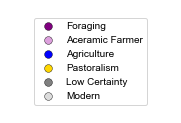

In [5]:
plot_legend(path_clst_clrs = "./Data/RegionDefinition/economy_colors_v3.csv", 
                figsize = (3,2), s=60, lw=0.4, savepath="./figures/manuscript/timelines/legend/legend_v6.pdf")

### Function to plot the map

### The Pilot. All other plots imitatet the parameters chosen here!
For Europe: Copy all stuff in the middle of the function.

### Define the Parameters

In [3]:
eu_params = {"figsize": (3.6, 1),
              "width_ratios": (8, 22), "height_ratios": [1.5, 15, 1], 
              "hspace": 0.08, "wspace": 0.015,
              "s_tl": 9, "ec":"k", "lw": 0.09, 
              "x_lim_tl": [-500, 12200], "vrange_m": [0,12200], 
              "y_lim_tl": [0,120], "fsl":5, "fs": 5, "fs_leg": 5, 
              "leg_loc_tl": "", "title_tl": "",
              "title_loc": (0.2,0.01), 
              "cm": 4, "cm1": 8, "frac": 0, 
              "lgth_s": [1500,1500], "lw_fit":1.5, 
              "ticks": [83.73, 30.98, 4.41], "tick_l":[],
              "cutoff": [20,50], "cousins_vec": [[20,50],[20,100]],  "m_cs": ["v", "s"],
              "s_cousins" : [9,14], "bg_c":"lightgrey",
              "width_t": 0.6, "length_t":2, "lbl_pad_time": 5, 
              "lbl_pad_age":0, "xl_pad": 1.5, "yl_pad": 1, 
              "widths": 800, "alpha_vio": 0.3}

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 2.67**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2.21)
Log-Marginal-Likelihood: -443.0207607095316
2
Saved to ./figures_test/timeline_test.pdf


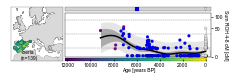

In [65]:
pop = "Iberia"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0, 12200], pop=pop)
label = prep_label(df_t, pop)

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38], map_title=label,
              bottomrow=True, rightcol=True,
              savepath="./figures_test/timeline_test.pdf", **eu_params)

In [36]:
### Output to check values
#df_t.sort_values(by="sum_roh>20", ascending=False)

## Timeline Plots of European Populations
Instructions: 
- Load the functions at top and just above.
- Run Populations one by one (use bottomrow and rightcol accordingly)
- Use Incscape or AI to combine the figures

# Produce European Panels (8 Figures, main manuscript)

## Britain [E1]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 2.33**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -288.170943147731
2
Saved to ./figures/manuscript/timelines/eu_panel_v6/E1.pdf


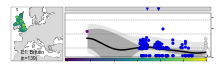

In [67]:
pop = "Britain"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, "E1: Britain")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38], map_title=label,
              bottomrow=False, rightcol=False, 
              savepath="./figures/manuscript/timelines/eu_panel_v6/E1.pdf",
              **eu_params)

### Baltic [E2]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 2.9**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=3.24)
Log-Marginal-Likelihood: -241.962983119431
2
Saved to ./figures/manuscript/timelines/eu_panel_v6/E2.pdf


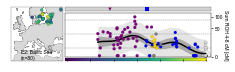

In [68]:
pop = "Baltic Sea"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, "E2: Baltic Sea")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38], 
              bottomrow=False, rightcol=True, map_title=label,
              savepath="./figures/manuscript/timelines/eu_panel_v6/E2.pdf",
              **eu_params)

## Central Europe [E3]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 4.39**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -318.33544728614305
2
Saved to ./figures/manuscript/timelines/eu_panel_v6/E3.pdf


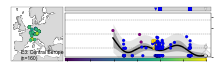

In [69]:
pop = "Central Europe"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, "E3: Central Europe")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38], map_title=label,
              bottomrow=False, rightcol=False, 
              savepath="./figures/manuscript/timelines/eu_panel_v6/E3.pdf", **eu_params)

In [71]:
#df_t[["iid", "pop", "economy", "age"]].sort_values(by="age", ascending=False)[:50]

### Black Sea [E4]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 2.42**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -52.77258245053822
2
Saved to ./figures/manuscript/timelines/eu_panel_v6/E4.pdf


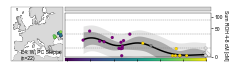

In [72]:
pop = "Black Sea"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, "E4: W. PC Steppe")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38], 
              map_title=label, bottomrow=False, rightcol=True, 
              savepath="./figures/manuscript/timelines/eu_panel_v6/E4.pdf",
              **eu_params)

### Central Italy [E5]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 3.78**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -206.13061235982127
2
Saved to ./figures/manuscript/timelines/eu_panel_v6/E5.pdf


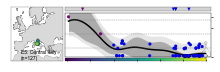

In [73]:
pop = "Central Italy"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, "E5: Central Italy")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38], map_title=label,
              bottomrow=False, rightcol=False,
              savepath="./figures/manuscript/timelines/eu_panel_v6/E5.pdf", **eu_params)

## Balkans [E6]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 2.2**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -267.12226776417504
2
Saved to ./figures/manuscript/timelines/eu_panel_v6/E6.pdf


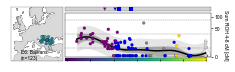

In [74]:
pop = "Balkans"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, "E6: Balkans")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38], 
              map_title=label, bottomrow=False, rightcol=True, 
              savepath="./figures/manuscript/timelines/eu_panel_v6/E6.pdf",
              **eu_params)

### Iberia [E7]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 2.67**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2.21)
Log-Marginal-Likelihood: -443.0207607095316
2
Saved to ./figures/manuscript/timelines/eu_panel_v6/E7.pdf


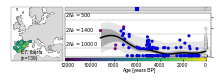

In [75]:
ib_params = eu_params.copy()
ib_params["tick_l"] = [f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"]

pop = "Iberia"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, "E7: Iberia")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38],
              map_title=label, bottomrow=True, rightcol=False,
              savepath="./figures/manuscript/timelines/eu_panel_v6/E7.pdf", **ib_params)

### Aegan [E8]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 2.23**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2.83)
Log-Marginal-Likelihood: -231.43105061141992
2
Saved to ./figures/manuscript/timelines/eu_panel_v6/E8.pdf


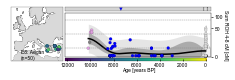

In [76]:
pop = "Aegan"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, "E8: Aegan")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38],
              map_title=label, bottomrow=True, rightcol=True,
              savepath="./figures/manuscript/timelines/eu_panel_v6/E8.pdf", **eu_params)

# Euro Supp [2 Panels, E9 & E10]

In [ ]:
plot_legend(path_clst_clrs = "./Data/RegionDefinition/economy_colors_v3.csv", 
                figsize = (3,2), s=60, lw=0.4, savepath="./figures/manuscript/timelines/supp_panel/legend_v6.pdf")

## Sardinia [E9, S3]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 1.74**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2.27)
Log-Marginal-Likelihood: -142.99986472799424
2
Saved to ./figures/manuscript/timelines/supp_panel/S3.pdf


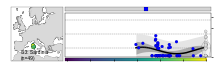

In [46]:
pop = "Sardinia"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, "S3: Sardinia")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38], 
              map_title=label, bottomrow=False, rightcol=False,
              savepath="./figures/manuscript/timelines/supp_panel/S3.pdf", 
              **eu_params)

### Eastern Europe [E10]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 1.29**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -245.35684745996062
2
Saved to ./figures/manuscript/timelines/supp_panel/S4.pdf


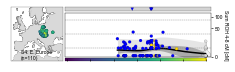

In [47]:
pop = "Eastern Europe"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0,12200], pop=pop)
label = prep_label(df_t, "S4: E. Europe")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38], 
              map_title=label, bottomrow=False, rightcol=True, 
              savepath="./figures/manuscript/timelines/supp_panel/S4.pdf",
              **eu_params)

In [82]:
dir_tozip = "./figures/manuscript/timelines/eu_panel_v6"
dir_zip = "./figures/manuscript/timelines/eu_panel_v6/eu_all.zip"
!zip -r -j $dir_zip $dir_tozip

  adding: E5.pdf (deflated 1%)
  adding: E1.pdf (deflated 1%)
  adding: E6.pdf (deflated 1%)
  adding: E2.pdf (deflated 1%)
  adding: E7.pdf (deflated 2%)
  adding: E3.pdf (deflated 1%)
  adding: E8.pdf (deflated 1%)
  adding: E4.pdf (deflated 1%)


### Levante

In [56]:
#tick_l=[f"$2N_e=500$", f"$2N_e=2000$"]
#ticks=[158.74, 83.82, 21.84]
ticks = [83.73, 30.98, 4.41]
tick_l = [f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"]
le_params = eu_params.copy()
le_params["tick_l"] = tick_l
le_params["ticks"] = ticks

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 1.67**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=3.78)
Log-Marginal-Likelihood: -322.23668289548175
2
Saved to ./figures/manuscript/timelines/eu_panel_v5/levante.pdf


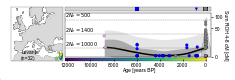

In [57]:
pop = "Levante"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0, 12200], pop=pop)
label = prep_label(df_t, pop)

plot_map_time(df_t, crs_m=[28, 63, -13, 38],
              map_title=label, bottomrow=True, rightcol=True,  
              savepath="./figures/manuscript/timelines/eu_panel_v5/levante.pdf",
              **le_params)

In [156]:
dir_tozip = "./figures/manuscript/timelines/eu_panel_v5"
dir_zip = "./figures/manuscript/timelines/eu_panel_v5/eu_all.zip"
!zip -r $dir_zip $dir_tozip

  adding: figures/manuscript/timelines/eu_panel_v5/ (stored 0%)
  adding: figures/manuscript/timelines/eu_panel_v5/britain.pdf (deflated 1%)
  adding: figures/manuscript/timelines/eu_panel_v5/.ipynb_checkpoints/ (stored 0%)
  adding: figures/manuscript/timelines/eu_panel_v5/.ipynb_checkpoints/levante-checkpoint.pdf (deflated 2%)
  adding: figures/manuscript/timelines/eu_panel_v5/baltic.pdf (deflated 2%)
  adding: figures/manuscript/timelines/eu_panel_v5/levante.pdf (deflated 3%)
  adding: figures/manuscript/timelines/eu_panel_v5/italy.pdf (deflated 1%)
  adding: figures/manuscript/timelines/eu_panel_v5/ce.pdf (deflated 1%)
  adding: figures/manuscript/timelines/eu_panel_v5/black_sea.pdf (deflated 2%)
  adding: figures/manuscript/timelines/eu_panel_v5/iberia.pdf (deflated 1%)
  adding: figures/manuscript/timelines/eu_panel_v5/balkans.pdf (deflated 2%)


### Combine all Figures for download

### North Africa and Aegan Panel

In [5]:
aegan_params = {"figsize": (3.6, 1),
              "width_ratios": (8, 22), "height_ratios": [1.5, 15, 1], 
              "hspace": 0.08, "wspace": 0.015,
              "s_tl": 9, "ec":"k", "lw": 0.09, 
              "x_lim_tl": [-500, 16000], "vrange_m": [0,16000], 
              "y_lim_tl": [0,120], "fsl":5, "fs": 5, "fs_leg": 5, 
              "leg_loc_tl": "", "title_tl": "",
              "title_loc": (0.2,0.01), 
              "cm": 4, "cm1": 8, "frac": 0, 
              "lgth_s": [2000,2000], "lw_fit":1.5, 
              "ticks" : [83.73, 30.98, 4.41],
              "cutoff": [20,50], "cousins_vec": [[20,50],[20,100]],  "m_cs": ["v", "s"],
              "s_cousins" : [9,14], "bg_c":"lightgrey",
              "width_t": 0.6, "length_t":2, "lbl_pad_time": 5, 
              "lbl_pad_age":0, "xl_pad": 1.5, "yl_pad": 1, 
              "widths": 800, "alpha_vio": 0.3}

Initial: 1**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2)
Optimum: 2.94**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2.85)
Log-Marginal-Likelihood: -235.22013055448105
2
Saved to ./figures/manuscript/timelines/aegan_panel_v5/aegan.pdf


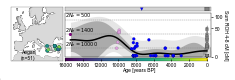

In [62]:
pop = "Aegan"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0, 16000], pop=pop)
label = prep_label(df_t, pop)

#title_loc=(0.2,0.01)
#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, crs_m=[28, 63, -13, 38], 
              map_title=label, bottomrow=True, rightcol=True,
              tick_l = [f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"],
              savepath="./figures/manuscript/timelines/aegan_panel_v5/aegan.pdf", 
              **aegan_params)

# Panel Ancients

## European HGs before 12,2 [HG0]

In [49]:
hg_params = {"figsize": (3.6, 1),
              "width_ratios": (8, 22), "height_ratios": [1.5, 15, 1], 
              "hspace": 0.08, "wspace": 0.015,
              "s_tl": 9, "ec":"k", "lw": 0.09, 
              "x_lim_tl": [12200, 46000], "vrange_m": [12200,46000], 
              "y_lim_tl": [0,120], "fsl":5, "fs": 5, "fs_leg": 5, 
              "leg_loc_tl": "", "title_tl": "",
              "title_loc": (0.25, 0.01), 
              "cm": 4, "cm1": 8, "frac": 0, 
              "lgth_s": [10000, 10000], "lw_fit":1.5, 
              "ticks" : [83.73, 30.98, 4.41],
              "cutoff": [20,50], "cousins_vec": [[20,50], [20,100]], "m_cs": ["v", "s"],
              "s_cousins" : [9,14], "bg_c":"lightgrey",
              "width_t": 0.6, "length_t":2, "lbl_pad_time": 5, 
              "lbl_pad_age":0, "xl_pad": 1.5, "yl_pad": 1, 
              "widths": 800, "alpha_vio": 0.3}

In [50]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[12200, 46000], pop="")
regions = ["North Africa", "Central Europe", "Eastern Europe", "Aegan", "Iberia"]
df_t = df_t[df_t["region"].str.contains("|".join(regions))]
label = prep_label(df_t, "C1: >12k BP")

2
Saved to ./figures/manuscript/timelines/hg_panel_v6/hg0.pdf


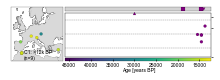

In [51]:
plot_map_time(df_t, crs_m=[28, 63, -13, 38], 
              map_title=label, bottomrow=True, rightcol=False,
              tick_l = [], std_band = 0,
              savepath="./figures/manuscript/timelines/hg_panel_v6/hg0.pdf",    # ./figures/manuscript/timelines/aegan_panel_v5/aegan.pdf
              **hg_params)

## Steppe Ancients before 12,2k BP [HG1]

2
Saved to ./figures/manuscript/timelines/hg_panel_v6/hg1.pdf


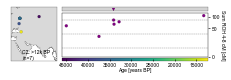

In [43]:
pop = "Steppe"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[12200, 46000], pop=pop)
df_t=df_t.sort_values(by="age", ascending=True)
label = prep_label(df_t, "C2: >12k BP")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label, tick_l = [], std_band = 0,
              crs_m=[0, 65, 26, 100],
              savepath="./figures/manuscript/timelines/hg_panel_v6/hg1.pdf",          
              **hg_params)

# Asia Panel [F]

In [3]:
steppe_params_all = {"figsize": (3.6, 1), "crs_m":[-18, 62, 26, 115],
              "width_ratios": (8, 22), "height_ratios": [1.5, 15, 1], 
              "hspace": 0.08, "wspace": 0.015,
              "s_tl": 9, "ec":"k", "lw": 0.09, 
              "x_lim_tl": [-500, 12200], "vrange_m": [0,12200], 
              "y_lim_tl": [0,120], "fsl":5, "fs": 5, "fs_leg": 5, 
              "leg_loc_tl": "", "title_tl": "",
              "title_loc": (0.35, 0.02), 
              "cm": 4, "cm1": 8, "frac": 0, 
              "lgth_s": [1500,1500], "lw_fit":1.5, 
              "ticks" : [83.73, 30.98, 4.41],
              "cutoff": [20,50], "cousins_vec": [[20,50],[20,100]],  "m_cs": ["v", "s"],
              "s_cousins" : [9,14], "bg_c":"lightgrey",
              "cutoff": [20,50], "m_cs": ["v", "s"], 
              "cousins_vec": [[20,50],[20,100]], 
              "s_cousins" : [9,14], "bg_c":"lightgrey",
              "width_t": 0.6, "length_t":2, "lbl_pad_time": 5, 
              "lbl_pad_age":0, "xl_pad": 1.5, "yl_pad": 1, 
              "widths": 800, "alpha_vio": 0.3}

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 2.71**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2.85)
Log-Marginal-Likelihood: -1036.527956879553
2
Saved to ./figures/manuscript/timelines/steppe_panel_v7/F1.pdf


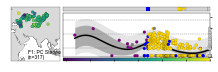

In [5]:
pop = "Steppe"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0, 12200], pop=pop)
df_t = df_t.sort_values(by="age", ascending=True)
label = prep_label(df_t, "F1: PC Steppe")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label,
              bottomrow=False, rightcol=False,
              tick_l=[],
              savepath="./figures/manuscript/timelines/steppe_panel_v7/F1.pdf",
              **steppe_params_all)

### East Steppe [K]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 3.96**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -98.2528999450681
2
Saved to ./figures/manuscript/timelines/steppe_panel_v7/F2.png


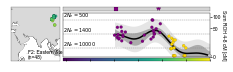

In [12]:
pop = "East Steppe"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0, 12200], pop=pop)
label = prep_label(df_t, "F2: Eastern Steppe")

#steppe_param_e = steppe_param_rec.copy()
#steppe_param_e["crs_m"] = [-30, 58, 90, 180]

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label, tick_l=[f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"], 
              savepath="./figures/manuscript/timelines/steppe_panel_v7/F2.png",
              bottomrow=False, rightcol=True,
              **steppe_params_all)

## Levant [L]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 1.67**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=3.78)
Log-Marginal-Likelihood: -322.23668289548175
2
Saved to ./figures/manuscript/timelines/steppe_panel_v7/F3.png


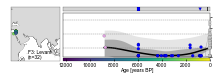

In [11]:
pop = "Levante"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0, 12200], pop=pop)
df_t=df_t.sort_values(by="age", ascending=True)
label = prep_label(df_t, "F3: Levant")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label, tick_l = [], #  [f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"]
              savepath="./figures/manuscript/timelines/steppe_panel_v7/F3.pdf", #./figures/manuscript/timelines/steppe_panel_v5/pakistan.pdf
              bottomrow=True, rightcol=False,
              **steppe_params_all)

## Central Asia [L]

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 2.28**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=3.23)
Log-Marginal-Likelihood: -703.7721731442348
2
Saved to ./figures/manuscript/timelines/steppe_panel_v7/F4.png


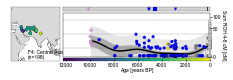

In [10]:
pop = "Central Asia"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0, 12200], pop=pop)
df_t=df_t.sort_values(by="age", ascending=True)
label = prep_label(df_t, "F4: Central Asia")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label, tick_l = [], #  [f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"]
              savepath="./figures/manuscript/timelines/steppe_panel_v7/F4.pdf",
              bottomrow=True, rightcol=True,
              **steppe_params_all)

In [80]:
dir_tozip = "./figures/manuscript/timelines/steppe_panel_v6"
dir_zip = "./figures/manuscript/timelines/steppe_panel_v6/steppe_all.zip"
!zip -r -j $dir_zip $dir_tozip

  adding: F4.pdf (deflated 1%)
  adding: F1.pdf (deflated 1%)
  adding: F2.pdf (deflated 2%)
  adding: F3.pdf (deflated 1%)


# South American Populations
Instructions: 
- Load the functions at top and just above.

In [10]:
sa_params = {"figsize": (3.6, 1),
             "crs_m":[-59, 57, -140, -25],
              "width_ratios": (8, 22), "height_ratios": [1.5, 15, 1], 
              "hspace": 0.08, "wspace": 0.015,
              "s_tl": 9, "ec":"k", "lw": 0.09, 
              "x_lim_tl": [-100, 13000], "vrange_m": [0,13000], 
              "y_lim_tl": [0,120], "fsl":5, "fs": 5, "fs_leg": 5, 
              "leg_loc_tl": "", "title_tl": "",
              "title_loc": (0.05,0.01), 
              "cm": 4, "cm1": 8, "frac": 0, 
              "lgth_s": [2000,2000], "lw_fit":1.5, 
              "ticks" : [83.73, 30.98, 4.41],
              "cutoff": [20,50], "m_cs": ["v", "s"], 
              "cousins_vec": [[20,50],[20,100]], 
              "s_cousins" : [9,14], "bg_c":"lightgrey",
              "width_t": 0.6, "length_t":2, "lbl_pad_time": 5, 
              "lbl_pad_age":0, "xl_pad": 1.5, "yl_pad": 1, 
              "widths": 800, "alpha_vio": 0.3}

### Pacific NW [D1]

Initial: 1**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2)
Optimum: 7.05**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2.3)
Log-Marginal-Likelihood: -34.23017000859323
2
Saved to ./figures/manuscript/timelines/sa_panel_v5/D1.pdf


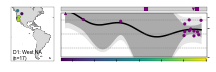

In [63]:
pop = "Pacific NW"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[100, 13000], pop=pop)
label = prep_label(df_t, "D1: West NA")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label, 
              savepath="./figures/manuscript/timelines/sa_panel_v5/D1.pdf",
              tick_l = [], bottomrow = False, rightcol=False,
              **sa_params)

### Andean [A3]

Initial: 1**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2)
Optimum: 6.5**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -52.33484292185372
2
Saved to ./figures/manuscript/timelines/sa_panel_v5/D3.pdf


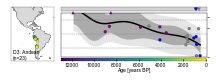

In [64]:
pop = "Andean"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[100, 13000], pop=pop)
label = prep_label(df_t, "D3: Andean")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label, 
              savepath="./figures/manuscript/timelines/sa_panel_v5/D3.pdf",
              tick_l = [],
              bottomrow = True, rightcol=False,
              **sa_params)

### Atlantic Coast [A2]

Initial: 1**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2)
Optimum: 5.51**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -29.88881775744764
2
Saved to ./figures/manuscript/timelines/sa_panel_v5/D2.pdf


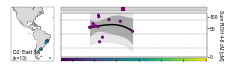

In [65]:
pop = "Atlantic Coast"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[500, 13000], pop=pop)
label = prep_label(df_t, "D2: East SA")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label, 
              savepath="./figures/manuscript/timelines/sa_panel_v5/D2.pdf",
              tick_l = [],
              bottomrow = False, rightcol=True,
              **sa_params)

### Patagonia [A4]

Initial: 1**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2)
Optimum: 7.91**2 * RBF(length_scale=2e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -18.61372516819521
2
Saved to ./figures/manuscript/timelines/sa_panel_v5/D4.pdf


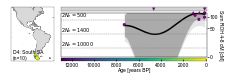

In [66]:
pop = "Patagonia"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0, 13000], pop=pop)
label = prep_label(df_t, "D4: South SA")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label, 
              savepath="./figures/manuscript/timelines/sa_panel_v5/D4.pdf",
              bottomrow = True, rightcol=True, 
              tick_l = [f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"],
              **sa_params)

In [67]:
dir_tozip = "./figures/manuscript/timelines/sa_panel_v5/"
dir_zip = "./figures/manuscript/timelines/sa_panel_v5/sa_all.zip"
!zip -r -j $dir_zip $dir_tozip

updating: D1.pdf (deflated 0%)
updating: D2.pdf (deflated 1%)
updating: D3.pdf (deflated 1%)
updating: D4.pdf (deflated 1%)


# Supplemental Figure

## Bering Sea

In [43]:
ber_params   = {"figsize": (3.6, 1),
              "width_ratios": (8, 22), "height_ratios": [1.5, 15, 1], 
              "hspace": 0.08, "wspace": 0.015,
              "s_tl": 9, "ec":"k", "lw": 0.09, 
              "x_lim_tl": [-100, 15000], "vrange_m": [0,15000], 
              "y_lim_tl": [0,120], "fsl":5, "fs": 5, "fs_leg": 5, 
              "leg_loc_tl": "", "title_tl": "",
              "title_loc": (0.05,0.01), 
              "cm": 4, "cm1": 8, "frac": 0, 
              "lgth_s": [1500,1500], "lw_fit":1.5, 
              "ticks" : [83.73, 30.98, 4.41],
              "cutoff": [20,50], "m_cs": ["v", "s"], "cousins_vec": [[20,50],[20,100]], 
              "s_cousins" : [9,14], "bg_c":"lightgrey",
              "width_t": 0.6, "length_t":2, "lbl_pad_time": 5, 
              "lbl_pad_age":0, "xl_pad": 1.5, "yl_pad": 1, 
              "widths": 800, "alpha_vio": 0.3}

In [44]:
pop = "Bering Sea"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[100, 15000], pop=pop)
label = prep_label(df_t, "S1: Bering Sea")
#df_t["color"] = "purple"

2
Saved to ./figures/manuscript/timelines/supp_panel/S1.pdf


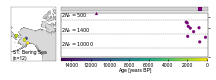

In [45]:
plot_map_time(df_t, map_title=label, crs_m=[40, 80, -180, -100],
              bottomrow=True, rightcol=False,
              std_band = 0,
              tick_l = [f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"], # f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"
              savepath="./figures/manuscript/timelines/supp_panel/S1.pdf",
              **ber_params)

## North Africa [N]

In [48]:
pop = "North Africa"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[100, 15000], pop=pop)
label = prep_label(df_t, "S2: North Africa")

2
Saved to ./figures/manuscript/timelines/supp_panel/S2.pdf


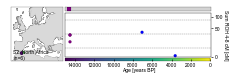

In [49]:
plot_map_time(df_t, map_title=label, crs_m=[28, 63, -13, 38],
              bottomrow=True, rightcol=True,
              std_band = 0,
              tick_l = [], # f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"
              savepath="./figures/manuscript/timelines/supp_panel/S2.pdf",
              **ber_params)

# Africa
South & Eeast Africa

In [34]:
af_params   = {"figsize": (3.6, 1),
              "width_ratios": (8, 22), "height_ratios": [1.5, 15, 1], 
              "hspace": 0.08, "wspace": 0.015,
              "s_tl": 9, "ec":"k", "lw": 0.09, 
              "x_lim_tl": [-100, 5000], "vrange_m": [0,5000], 
              "y_lim_tl": [0,120], "fsl":5, "fs": 5, "fs_leg": 5, 
              "leg_loc_tl": "", "title_tl": "",
              "title_loc": (0.05,0.01), 
              "cm": 4, "cm1": 8, "frac": 0, 
              "lgth_s": [1500,1500], "lw_fit":1.5, 
              "ticks" : [83.73, 30.98, 4.41],
              "cutoff": [20,50], "m_cs": ["v", "s"], "cousins_vec": [[20,50],[20,100]], 
              "s_cousins" : [9,14], "bg_c":"lightgrey",
              "width_t": 0.6, "length_t":2, "lbl_pad_time": 5, 
              "lbl_pad_age":0, "xl_pad": 1.5, "yl_pad": 1, 
              "widths": 800, "alpha_vio": 0.3}

### East Africa

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 1.46**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -48.22319272045034
2
Saved to ./figures/manuscript/timelines/supp_panel/S8.pdf


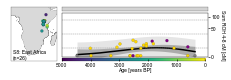

In [35]:
pop = "East Africa"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[100, 13000], pop=pop)
label = prep_label(df_t, "S8: East Africa")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label, crs_m=[-40, 15, 0, 50],
              bottomrow=True, rightcol=True,
              tick_l = [], # f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"
              savepath="./figures/manuscript/timelines/supp_panel/S8.pdf",
              **af_params)

### South Africa

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 1.67**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Log-Marginal-Likelihood: -15.0424563359277
2
Saved to ./figures/manuscript/timelines/supp_panel/S7.pdf


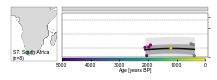

In [36]:
pop = "South Africa"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[100, 13000], pop=pop)
label = prep_label(df_t, "S7: South Africa")


#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label, crs_m=[-40, 15, 0, 50],
              bottomrow=True, rightcol=False, tick_l=[], 
              savepath="./figures/manuscript/timelines/supp_panel/S7.pdf",
              **af_params)

## Tibet [T]

In [37]:
him_params  = {"figsize": (3.6, 1),
              "crs_m":[0, 65, 26, 100],
              "width_ratios": (8, 22), "height_ratios": [1.5, 15, 1], 
              "hspace": 0.08, "wspace": 0.015,
              "s_tl": 9, "ec":"k", "lw": 0.09, 
              "x_lim_tl": [-100, 3500], "vrange_m": [0,3500], 
              "y_lim_tl": [0,120], "fsl":5, "fs": 5, "fs_leg": 5, 
              "leg_loc_tl": "", "title_tl": "",
              "title_loc": (0.05,0.01), 
              "cm": 4, "cm1": 8, "frac": 0, 
              "lgth_s": [1500,1500], "lw_fit":1.5, 
              "ticks" : [83.73, 30.98, 4.41],
              "cutoff": [20,50], "cousins_vec": [[20,50],[20,100]], "m_cs":["v", "s"],
              "s_cousins" : [9,9], "bg_c":"lightgrey",
              "width_t": 0.6, "length_t":2, "lbl_pad_time": 5, 
              "lbl_pad_age":0, "xl_pad": 1.5, "yl_pad": 1, 
              "widths": 800, "alpha_vio": 0.3}

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 2.9**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -49.61279017617457
2
Saved to ./figures/manuscript/timelines/supp_panel/S5.pdf


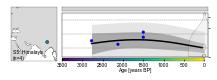

In [38]:
pop = "Himalaya"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0, 13000], pop=pop)
df_t.loc[df_t["age"]>0, "color"] = "blue"
label = prep_label(df_t, "S5: Himalaya")

#tick_l=[f"$2N_e=250$", f"$2N_e=500$", f"$2N_e=2000$"]
plot_map_time(df_t, map_title=label,
              rightcol=False,
              savepath="./figures/manuscript/timelines/supp_panel/S5.pdf",
              tick_l = [], # f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"
              **him_params)

### Vanuatu [V]

In [39]:
vanuatu_params  = {"figsize": (3.6, 1),
              "crs_m":[-30, 58, 90, 180],
              "width_ratios": (8, 22), "height_ratios": [1.5, 15, 1], 
              "hspace": 0.08, "wspace": 0.015,
              "s_tl": 9, "ec":"k", "lw": 0.09, 
              "x_lim_tl": [-100, 3500], "vrange_m": [0,3500], 
              "y_lim_tl": [0,120], "fsl":5, "fs": 5, "fs_leg": 5, 
              "leg_loc_tl": "", "title_tl": "",
              "title_loc": (0.05,0.01), 
              "cm": 4, "cm1": 8, "frac": 0, 
              "lgth_s": [1500,1500], "lw_fit":1.5, 
              "ticks" : [83.73, 30.98, 4.41],
              "cutoff": [20,50], "cousins_vec": [[20,50],[20,100]], "m_cs":["v", "s"],
              "s_cousins" : [9,9], "bg_c":"lightgrey",
              "width_t": 0.6, "length_t":2, "lbl_pad_time": 5, 
              "lbl_pad_age":0, "xl_pad": 1.5, "yl_pad": 1, 
              "widths": 800, "alpha_vio": 0.3}

Initial: 1**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=2)
Optimum: 3.03**2 * RBF(length_scale=1.5e+03) + WhiteKernel(noise_level=4)
Log-Marginal-Likelihood: -37.15264294836078
2
Saved to ./figures/manuscript/timelines/supp_panel/S6.pdf


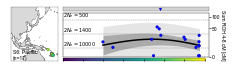

In [40]:
pop = "Vanuatu"
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")
df_t = extract_pop(df1, age_range=[0, 13000], pop=pop)
df_t["color"] = "blue"
label = prep_label(df_t, "S6: Pacific")

plot_map_time(df_t, map_title=label,
              rightcol=True, bottomrow=False,
              savepath="./figures/manuscript/timelines/supp_panel/S6.pdf",
              tick_l = [f"$2N_e=500$", f"$2N_e=1400$", f"$2N_e=10000$"],
              **vanuatu_params)

In [50]:
dir_tozip = "./figures/manuscript/timelines/supp_panel"
dir_zip = "./figures/manuscript/timelines/supp_panel/all.zip"
!zip -r -j $dir_zip $dir_tozip

  adding: S4.pdf (deflated 1%)
  adding: S5.pdf (deflated 1%)
  adding: S1.pdf (deflated 2%)
  adding: S6.pdf (deflated 1%)
  adding: S2.pdf (deflated 2%)
  adding: S7.pdf (deflated 3%)
  adding: S3.pdf (deflated 1%)
  adding: S8.pdf (deflated 3%)
  adding: legend_v6.pdf (deflated 32%)


# Area 51

### Experiment with small font size

In [3]:
df1 = pd.read_csv("./Empirical/roh_all_inds_final_v42.csv", sep="\t")

In [ ]:
df1.sort_values(by="sum_roh>20", ascending=False)[:20]